In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [3]:
Y_A = np.array([100, 110, 55, 210, 32, 155, 85, 125, 73, 95, 115, 200])
Y_B = np.array([100, 120, 60, 230, 35, 165, 90, 135, 78, 100, 125, 195])
# Предэкспериментальные данные (одинаковые для обеих групп)
X = np.array([98, 100, 50, 200, 30, 150, 80, 120, 70, 90, 110, 170])

#  t-тест
t_stat, p_value = stats.ttest_ind(Y_A, Y_B)
print(f"t = {t_stat:.3f}, p = {p_value:.4f}")
print(f"Mean A: {Y_A.mean():.1f}, Mean B: {Y_B.mean():.1f}")
print(f"Difference: {Y_B.mean() - Y_A.mean():.1f}")
print(f"Std A: {Y_A.std():.1f}, Std B: {Y_B.std():.1f}")

t = -0.291, p = 0.7740
Mean A: 112.9, Mean B: 119.4
Difference: 6.5
Std A: 51.4, Std B: 53.5


p = 0.7740 > 0.05 не опровергаем H0

In [8]:
# 1. Рассчитываем θ (коэффициент регрессии)
# Объединяем данные для оценки θ
Y_all = np.concatenate([Y_A, Y_B])
X_all = np.concatenate([X, X])

# θ = cov(X,Y) / var(X)
cov_xy = np.cov(X_all, Y_all)[0, 1]
var_x = np.var(X_all, ddof=1)
theta = cov_xy / var_x
print(f"\nθ (коэффициент) = {theta:.4f}")

# 2. Применяем CUPED корректировку
def apply_cuped(Y, X, theta):
    X_mean = X.mean()
    Y_cuped = Y - theta * (X - X_mean)
    return Y_cuped

Y_A_cuped = apply_cuped(Y_A, X, theta)
Y_B_cuped = apply_cuped(Y_B, X, theta)

# 3. t-тест на скорректированных данных
t_stat_cuped, p_value_cuped = stats.ttest_ind(Y_A_cuped, Y_B_cuped)
print(f"\nС CUPED: t = {t_stat_cuped:.3f}, p = {p_value_cuped:.6f}")
print(f"Mean A (cuped): {Y_A_cuped.mean():.1f}, Mean B (cuped): {Y_B_cuped.mean():.1f}")
print(f"Difference (cuped): {Y_B_cuped.mean() - Y_A_cuped.mean():.1f}")
print(f"Std A (cuped): {Y_A_cuped.std():.1f}, Std B (cuped): {Y_B_cuped.std():.1f}")

# 4. Считаем уменьшение дисперсии
var_reduction = 1 - (Y_A_cuped.var() / Y_A.var())
print(f"\nСнижение дисперсии: {var_reduction:.2%}")


θ (коэффициент) = 1.1139

С CUPED: t = -2.868, p = 0.008934
Mean A (cuped): 112.9, Mean B (cuped): 119.4
Difference (cuped): 6.5
Std A (cuped): 6.0, Std B (cuped): 4.5

Снижение дисперсии: 98.62%


p = 0.008934 < 0.05 - опровергаем H0

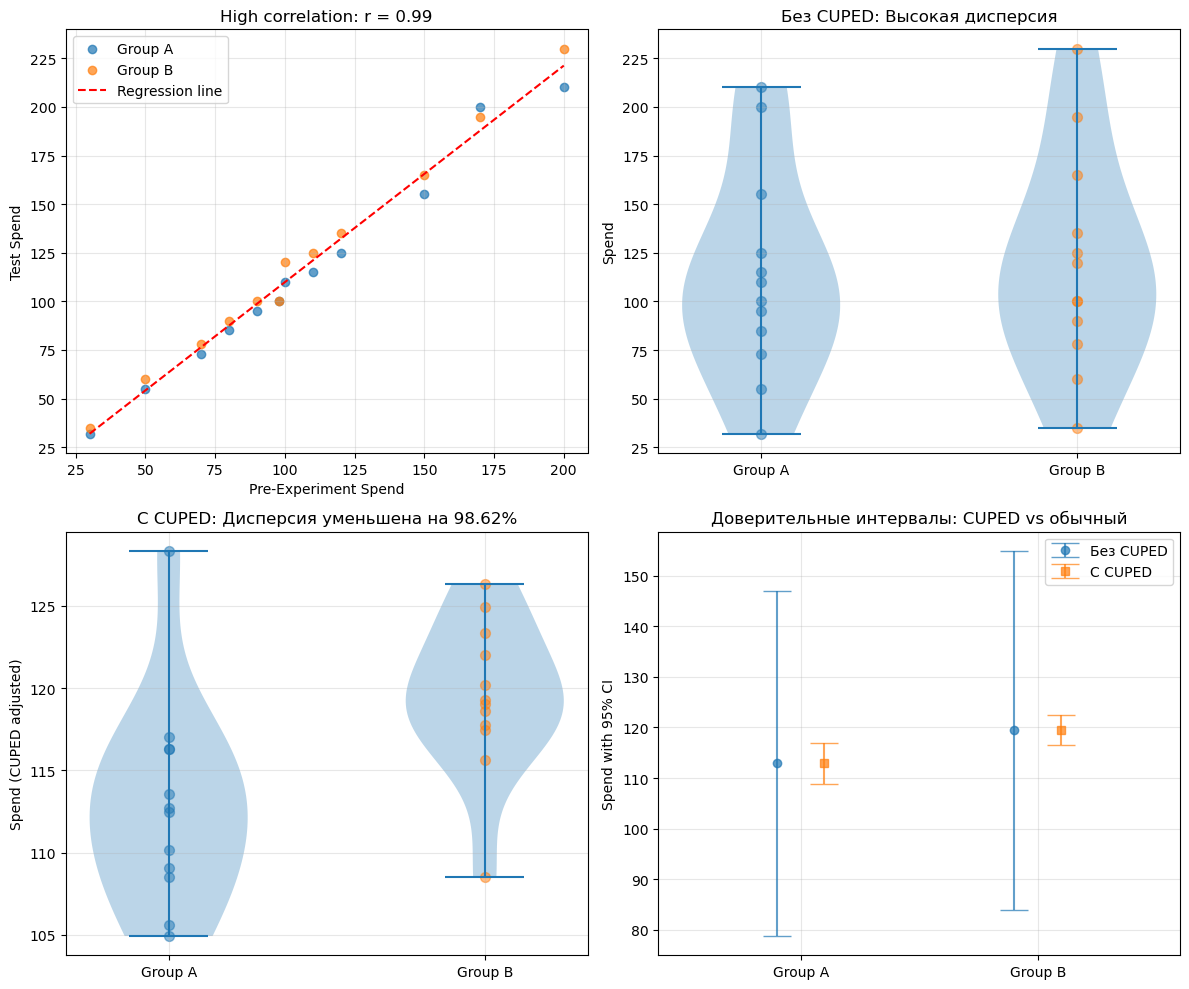

In [9]:
# Создаем DataFrame для визуализации
df = pd.DataFrame({
    'User': np.arange(1, 13),
    'Pre_Spend': X,
    'Spend_A': Y_A,
    'Spend_B': Y_B,
    'Spend_A_cuped': Y_A_cuped,
    'Spend_B_cuped': Y_B_cuped
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Корреляция Pre-Test vs Test
axes[0, 0].scatter(X, Y_A, alpha=0.7, label='Group A')
axes[0, 0].scatter(X, Y_B, alpha=0.7, label='Group B')
z = np.polyfit(X_all, Y_all, 1)
p = np.poly1d(z)
axes[0, 0].plot(np.sort(X), p(np.sort(X)), 'r--', label=f'Regression line')
axes[0, 0].set_xlabel('Pre-Experiment Spend')
axes[0, 0].set_ylabel('Test Spend')
axes[0, 0].set_title(f'High correlation: r = {np.corrcoef(X_all, Y_all)[0,1]:.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Сравнение распределений (без CUPED)
axes[0, 1].violinplot([Y_A, Y_B], positions=[1, 2])
axes[0, 1].scatter([1]*len(Y_A), Y_A, alpha=0.5, s=50)
axes[0, 1].scatter([2]*len(Y_B), Y_B, alpha=0.5, s=50)
axes[0, 1].set_xticks([1, 2])
axes[0, 1].set_xticklabels(['Group A', 'Group B'])
axes[0, 1].set_ylabel('Spend')
axes[0, 1].set_title('Без CUPED: Высокая дисперсия')
axes[0, 1].grid(True, alpha=0.3)

# 3. Сравнение распределений (с CUPED)
axes[1, 0].violinplot([Y_A_cuped, Y_B_cuped], positions=[1, 2])
axes[1, 0].scatter([1]*len(Y_A_cuped), Y_A_cuped, alpha=0.5, s=50)
axes[1, 0].scatter([2]*len(Y_B_cuped), Y_B_cuped, alpha=0.5, s=50)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Group A', 'Group B'])
axes[1, 0].set_ylabel('Spend (CUPED adjusted)')
axes[1, 0].set_title(f'С CUPED: Дисперсия уменьшена на {var_reduction:.2%}')
axes[1, 0].grid(True, alpha=0.3)

# 4. Confidence intervals
def mean_ci(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean-h, mean+h

ci_a = mean_ci(Y_A)
ci_b = mean_ci(Y_B)
ci_a_cuped = mean_ci(Y_A_cuped)
ci_b_cuped = mean_ci(Y_B_cuped)

axes[1, 1].errorbar([1, 2], [ci_a[0], ci_b[0]], 
                   yerr=[[ci_a[0]-ci_a[1], ci_b[0]-ci_b[1]], 
                         [ci_a[2]-ci_a[0], ci_b[2]-ci_b[0]]],
                   fmt='o', capsize=10, label='Без CUPED', alpha=0.7)
axes[1, 1].errorbar([1.2, 2.2], [ci_a_cuped[0], ci_b_cuped[0]],
                   yerr=[[ci_a_cuped[0]-ci_a_cuped[1], ci_b_cuped[0]-ci_b_cuped[1]],
                         [ci_a_cuped[2]-ci_a_cuped[0], ci_b_cuped[2]-ci_b_cuped[0]]],
                   fmt='s', capsize=10, label='С CUPED', alpha=0.7)
axes[1, 1].set_xlim(0.5, 2.7)
axes[1, 1].set_xticks([1.1, 2.1])
axes[1, 1].set_xticklabels(['Group A', 'Group B'])
axes[1, 1].set_ylabel('Spend with 95% CI')
axes[1, 1].set_title('Доверительные интервалы: CUPED vs обычный')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Пример с генерацией данных

In [19]:
Y_A = np.random.normal(100, 10, 1000)
Y_B = np.random.normal(100.5, 10, 1000)
# Предэкспериментальные данные (одинаковые для обеих групп)
X = np.random.normal(99, 10, 1000)

In [32]:
# Параметры
n = 1000
base_mean = 100
effect = 0.5  # Разница между группами
std = 10
desired_correlation = 0.8  # Желаемая корреляция

# 1. Генерируем X (предэкспериментальные данные)
X = np.random.normal(base_mean, std, n)

# 2. Генерируем "истинный" Y (без шума)
Y_true = base_mean + desired_correlation * std * (X - base_mean) / std

# 3. Добавляем шум для получения желаемой корреляции
# Формула: Y = ρ*σ_y/σ_x * X + ε, где var(ε) = (1-ρ²)*σ_y²
noise_std = std * np.sqrt(1 - desired_correlation**2)
noise = np.random.normal(0, noise_std, n)
Y_base = Y_true + noise

# 4. Разделяем на группы A и B
# Группа A: без эффекта
Y_A = Y_base[:n//2]

# Группа B: с эффектом +0.5
Y_B = Y_base[n//2:] + effect

# Соответствующие X для каждой группы
X_A = X[:n//2]
X_B = X[n//2:]

In [33]:
#  t-тест
t_stat, p_value = stats.ttest_ind(Y_A, Y_B)
print(f"t = {t_stat:.3f}, p = {p_value:.4f}")
print(f"Mean A: {Y_A.mean():.1f}, Mean B: {Y_B.mean():.1f}")
print(f"Difference: {Y_B.mean() - Y_A.mean():.1f}")
print(f"Std A: {Y_A.std():.1f}, Std B: {Y_B.std():.1f}")

t = -1.249, p = 0.2121
Mean A: 99.9, Mean B: 100.7
Difference: 0.8
Std A: 10.4, Std B: 10.0


p = 0.2121 > 0.05 не опровергаем H0

In [34]:
# 1. Рассчитываем θ (коэффициент регрессии)
# Объединяем данные для оценки θ
Y_all = np.concatenate([Y_A, Y_B])
X_all = np.concatenate([X_A, X_B])
print(f'len Y_all {len(Y_all)} , len X_all {len(X_all)}')

# θ = cov(X,Y) / var(X)
cov_xy = np.cov(X_all, Y_all)[0, 1]
var_x = np.var(X_all, ddof=1)
theta = cov_xy / var_x
print(f"\nθ (коэффициент) = {theta:.4f}")

# 2. Применяем CUPED корректировку
def apply_cuped(Y, X, theta):
    X_mean = X.mean()
    Y_cuped = Y - theta * (X - X_mean)
    return Y_cuped

Y_A_cuped = apply_cuped(Y_A, X_A, theta)
Y_B_cuped = apply_cuped(Y_B, X_B, theta)

# 3. t-тест на скорректированных данных
t_stat_cuped, p_value_cuped = stats.ttest_ind(Y_A_cuped, Y_B_cuped)
print(f"\nС CUPED: t = {t_stat_cuped:.3f}, p = {p_value_cuped:.6f}")
print(f"Mean A (cuped): {Y_A_cuped.mean():.1f}, Mean B (cuped): {Y_B_cuped.mean():.1f}")
print(f"Difference (cuped): {Y_B_cuped.mean() - Y_A_cuped.mean():.1f}")
print(f"Std A (cuped): {Y_A_cuped.std():.1f}, Std B (cuped): {Y_B_cuped.std():.1f}")

# 4. Считаем уменьшение дисперсии
var_reduction = 1 - (Y_A_cuped.var() / Y_A.var())
print(f"\nСнижение дисперсии: {var_reduction:.2%}")

len Y_all 1000 , len X_all 1000

θ (коэффициент) = 0.7868

С CUPED: t = -2.052, p = 0.040443
Mean A (cuped): 99.9, Mean B (cuped): 100.7
Difference (cuped): 0.8
Std A (cuped): 6.5, Std B (cuped): 5.9

Снижение дисперсии: 61.27%


p = 0.040443 < 0.05 - опровергаем H0

In [40]:
print(len(X_A), len(Y_A), len(Y_B), len(np.arange(1, 500)))

500 500 500 499


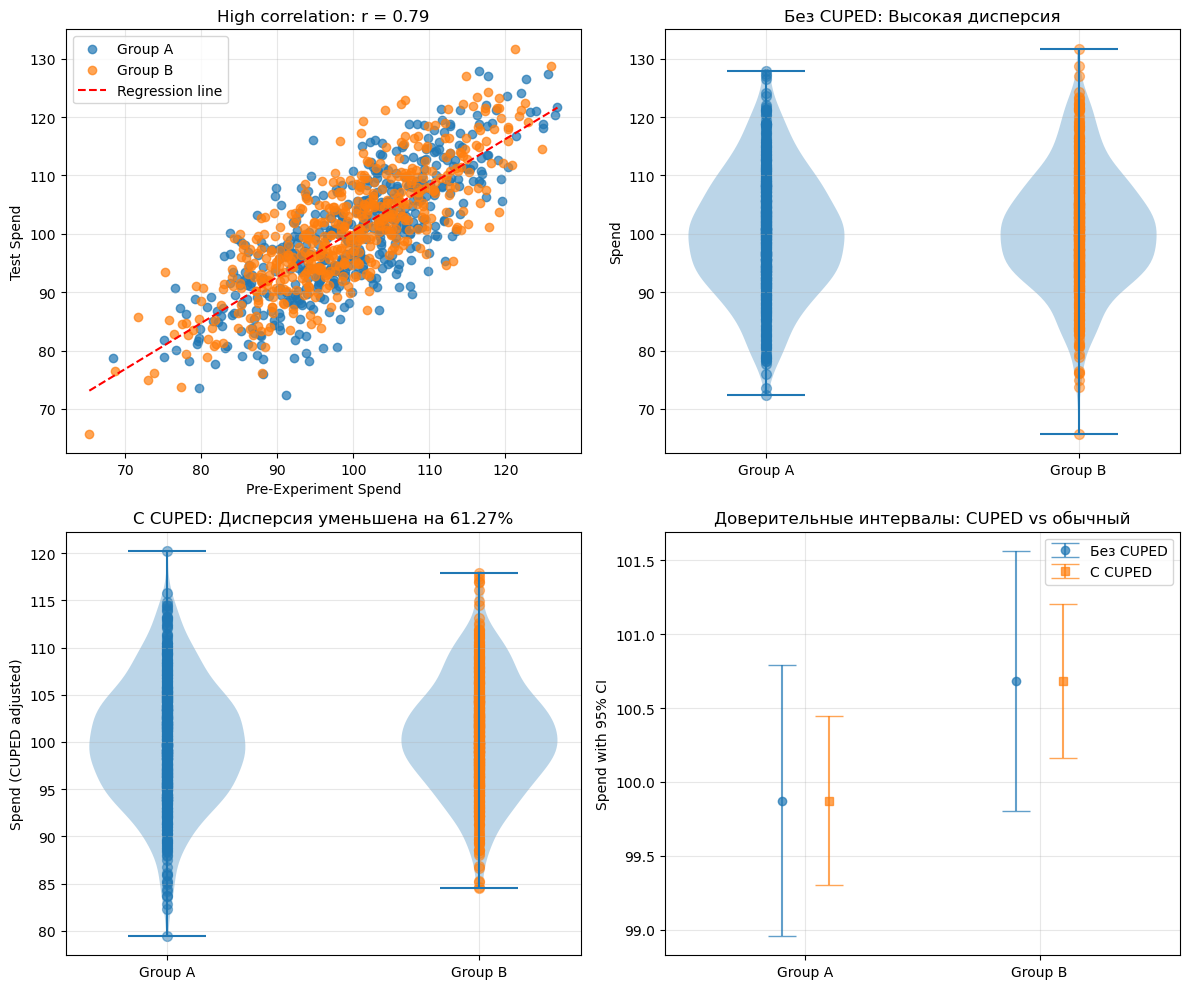

In [42]:
# Создаем DataFrame для визуализации
df = pd.DataFrame({
    'User': np.arange(1, 501),
    'Pre_Spend': X_A,
    'Spend_A': Y_A,
    'Spend_B': Y_B,
    'Spend_A_cuped': Y_A_cuped,
    'Spend_B_cuped': Y_B_cuped
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Корреляция Pre-Test vs Test
axes[0, 0].scatter(X_A, Y_A, alpha=0.7, label='Group A')
axes[0, 0].scatter(X_B, Y_B, alpha=0.7, label='Group B')
z = np.polyfit(X_all, Y_all, 1)
p = np.poly1d(z)
axes[0, 0].plot(np.sort(X), p(np.sort(X)), 'r--', label=f'Regression line')
axes[0, 0].set_xlabel('Pre-Experiment Spend')
axes[0, 0].set_ylabel('Test Spend')
axes[0, 0].set_title(f'High correlation: r = {np.corrcoef(X_all, Y_all)[0,1]:.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Сравнение распределений (без CUPED)
axes[0, 1].violinplot([Y_A, Y_B], positions=[1, 2])
axes[0, 1].scatter([1]*len(Y_A), Y_A, alpha=0.5, s=50)
axes[0, 1].scatter([2]*len(Y_B), Y_B, alpha=0.5, s=50)
axes[0, 1].set_xticks([1, 2])
axes[0, 1].set_xticklabels(['Group A', 'Group B'])
axes[0, 1].set_ylabel('Spend')
axes[0, 1].set_title('Без CUPED: Высокая дисперсия')
axes[0, 1].grid(True, alpha=0.3)

# 3. Сравнение распределений (с CUPED)
axes[1, 0].violinplot([Y_A_cuped, Y_B_cuped], positions=[1, 2])
axes[1, 0].scatter([1]*len(Y_A_cuped), Y_A_cuped, alpha=0.5, s=50)
axes[1, 0].scatter([2]*len(Y_B_cuped), Y_B_cuped, alpha=0.5, s=50)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Group A', 'Group B'])
axes[1, 0].set_ylabel('Spend (CUPED adjusted)')
axes[1, 0].set_title(f'С CUPED: Дисперсия уменьшена на {var_reduction:.2%}')
axes[1, 0].grid(True, alpha=0.3)

# 4. Confidence intervals
def mean_ci(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean-h, mean+h

ci_a = mean_ci(Y_A)
ci_b = mean_ci(Y_B)
ci_a_cuped = mean_ci(Y_A_cuped)
ci_b_cuped = mean_ci(Y_B_cuped)

axes[1, 1].errorbar([1, 2], [ci_a[0], ci_b[0]], 
                   yerr=[[ci_a[0]-ci_a[1], ci_b[0]-ci_b[1]], 
                         [ci_a[2]-ci_a[0], ci_b[2]-ci_b[0]]],
                   fmt='o', capsize=10, label='Без CUPED', alpha=0.7)
axes[1, 1].errorbar([1.2, 2.2], [ci_a_cuped[0], ci_b_cuped[0]],
                   yerr=[[ci_a_cuped[0]-ci_a_cuped[1], ci_b_cuped[0]-ci_b_cuped[1]],
                         [ci_a_cuped[2]-ci_a_cuped[0], ci_b_cuped[2]-ci_b_cuped[0]]],
                   fmt='s', capsize=10, label='С CUPED', alpha=0.7)
axes[1, 1].set_xlim(0.5, 2.7)
axes[1, 1].set_xticks([1.1, 2.1])
axes[1, 1].set_xticklabels(['Group A', 'Group B'])
axes[1, 1].set_ylabel('Spend with 95% CI')
axes[1, 1].set_title('Доверительные интервалы: CUPED vs обычный')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()